In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import blackjack as bj
from blackjack import Hand, HandScore, Action, make_hand
import simulator as sim
import optimizer as opt

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False, drawn=False)

In [10]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False, drawn=False)

In [11]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False, drawn=False)

In [12]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False, drawn=False), True)

In [13]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False, drawn=False)

In [14]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=s12, cards=[1, 1], doubled=False, drawn=False)

In [15]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h12, cards=[1, 1, 11], doubled=False, drawn=False)

In [16]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False, drawn=False), True)

## Now define gameplay and strategy

In [17]:
[bj.deal_card() for _ in range(10)]

[4, 13, 7, 3, 11, 8, 8, 1, 9, 3]

In [18]:
bj.play_one_round([bj.strat_nobust, bj.strat_nobust])

[('strat_nobust',
  Hand(score=h15, cards=[12, 5], doubled=False, drawn=False),
  Hand(score=h19, cards=[5, 5, 9], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('strat_nobust',
  Hand(score=h15, cards=[12, 5], doubled=False, drawn=False),
  Hand(score=h19, cards=[5, 5, 9], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>)]

## Aggregate and summarize the data from the simulations

In [19]:


strat_nobust = bj.strat_nobust
strat_dealer = bj.strat_dealer
sim.generate_rows_from_round(bj.play_one_round([bj.strat_nobust, bj.strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [7, 13],
  'dealer_card': 11,
  'hand_end': [7, 13],
  'dealer_hand': [11, 2, 6],
  'outcome': <HandOutcome.LOSE: -1>},
 {'strategy': 'strat_dealer',
  'hand_start': [7, 13],
  'dealer_card': 11,
  'hand_end': [7, 13],
  'dealer_hand': [11, 2, 6],
  'outcome': <HandOutcome.LOSE: -1>}]

In [20]:


sim_results = sim.run_n_sim_trials([strat_nobust, strat_dealer], 10000)
#%prun -s cumulative sim_results, sim.summarize_totals(sim_results)

In [21]:
def strat_simple_func(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple_func.name = 'simple'

strat_simple = bj.Strategy_wrapper(strat_simple_func)
sims = sim.run_n_sim_trials([strat_simple], 1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card       hand_end    dealer_hand  \
 0   simple    [10, 9]           12        [10, 9]     [12, 4, 8]   
 1   simple     [6, 4]            3      [6, 4, 1]  [3, 4, 4, 10]   
 2   simple     [8, 4]            5         [8, 4]      [5, 6, 7]   
 3   simple    [8, 13]            7        [8, 13]      [7, 5, 5]   
 4   simple    [7, 11]            3        [7, 11]  [3, 6, 5, 10]   
 5   simple     [3, 3]           13  [3, 3, 6, 13]       [13, 10]   
 6   simple    [10, 1]           13        [10, 1]     [13, 5, 5]   
 7   simple    [11, 7]            7        [11, 7]        [7, 12]   
 8   simple    [12, 9]            6        [12, 9]     [6, 6, 12]   
 9   simple    [13, 1]            1        [13, 1]         [1, 8]   
 
                  outcome  outcome_value outcome_name  
 0        HandOutcome.WIN            1.0          WIN  
 1       HandOutcome.PUSH            0.0         PUSH  
 2       HandOutcome.LOSE           -1.0         LOSE  
 3        HandO

In [22]:
%prun -s cumulative sim.summarize_totals(sim.run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


## Simulate specific situations to determine strategy

In [23]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False, drawn=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False))

In [24]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]


    
strat_cond = sim.generate_strat_conditional(strat_simple, conditions)
strat_cond

In [25]:
# Generate a conditional strategy for each action
    
strats = sim.gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

In [26]:
bj.complete_one_round(strats, hand_p, hand_d, bj.deal_card())

[('<Action.HIT: 2>',
  Hand(score=h22, cards=[5, 7, 12], doubled=False, drawn=True),
  Hand(score=h18, cards=[2, 7, 6, 3], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False, drawn=False),
  Hand(score=h18, cards=[2, 7, 6, 3], doubled=False, drawn=True),
  <HandOutcome.LOSE: -1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h22, cards=[5, 7, 10], doubled=True, drawn=True),
  Hand(score=h18, cards=[2, 7, 6, 3], doubled=False, drawn=True),
  <HandOutcome.LOSE_DOUBLE: -2>)]

In [27]:


sims = sim.run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5935  482     0       3583      -0.4704
<Action.HIT: 2>     6078           0  665  3257          0      -0.2821
<Action.STAND: 1>   6300           0    0  3700          0      -0.2600

In [28]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=s12, cards=[1, 1], doubled=False, drawn=False),
 Hand(score=h02, cards=[2], doubled=False, drawn=False))

In [29]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = sim.gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

In [30]:
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6346    0     0       3654      -0.5384
<Action.HIT: 2>     5264           0  812  3924          0      -0.1340
<Action.STAND: 1>   6346           0    0  3654          0      -0.2692
simple              5310           0  762  3928          0      -0.1382

In [31]:
sim.summarize_totals(sim.run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6053  642  3305      -0.2748
strat_cond    6289    0  3711      -0.2578

In [32]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = sim.gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5827    0     0       4173      -0.3308
<Action.HIT: 2>     4877           0  326  4797          0      -0.0080
<Action.STAND: 1>   5827           0    0  4173          0      -0.1654
simple              5827           0    0  4173          0      -0.1654

In [33]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = sim.gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = sim.run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
sim.summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        3262  707     0       6031       0.5538
<Action.HIT: 2>     3251           0  698  6051          0       0.2800
<Action.STAND: 1>   5778           0    0  4222          0      -0.1556
simple              3236           0  699  6065          0       0.2829

In [34]:
sim.test_cond(HandScore(10), HandScore(6), 10000, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3276  671     0       6053       0.5554
 <Action.HIT: 2>     3266           0  707  6027          0       0.2761
 <Action.STAND: 1>   5839           0    0  4161          0      -0.1678)

In [35]:
sim.test_cond(HandScore(18), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         159    5    0         36       -1.230
 <Action.HIT: 2>     157           0    6   37          0       -0.600
 <Action.STAND: 1>    53           0   21  126          0        0.365)

In [36]:
sim.test_cond(HandScore(21, True), HandScore(6), 200, strat_simple)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          76    5    0        119        0.430
 <Action.HIT: 2>      78           0   15  107          0        0.145
 <Action.STAND: 1>     0           0   17  183          0        0.915)

In [37]:

sim.find_winning_action(HandScore(10), HandScore(6), 200)

{'<Action.DOUBLE: 3>': 0.69,
 '<Action.HIT: 2>': 0.425,
 '<Action.STAND: 1>': -0.11,
 'score_p': 'h10',
 'score_d': 'h06',
 'winning_act': <Action.DOUBLE: 3>,
 'winning_act_outcome': 0.69}

In [38]:
sim.test_cond(HandScore(18), HandScore(11, True), 1000)

(<function simulator.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         878   18    0        104       -1.548
 <Action.HIT: 2>     861           0   31  108          0       -0.753
 <Action.STAND: 1>   612           0  105  283          0       -0.329)

In [39]:
%prun -s cumulative conds = sim.compute_instructions(20)
pd.DataFrame(conds).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h09     s11                    -0.7           -0.300              -0.70   
        h02                     0.0           -0.250              -0.50   
        h03                     0.2            0.250              -0.10   
        h04                     0.2           -0.100              -0.30   
        h05                    -0.1            0.275              -0.30   
...                             ...              ...                ...   
s21     h06                     0.3            0.300               0.90   
        h07                     0.7            0.050               0.85   
        h08                     0.2            0.475               1.00   
        h09                    -0.5            0.400               0.85   
        h10                    -0.4           -0.250               0.60   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h09     s11         Action.HIT               -0.300  
        h02      Action.DOUBLE                0.000  
        h03         Action.HIT                0.250  
        h04      Action.DOUBLE                0.200  
        h05         Action.HIT                0.275  
...                        ...                  ...  
s21     h06       Action.STAND                0.900  
        h07       Action.STAND                0.850  
        h08       Action.STAND                1.000  
        h09       Action.STAND                0.850  
        h10       Action.STAND                0.600  

[250 rows x 5 columns]

In [40]:

%prun -s cumulative sim.compute_instructions(100, strat_simple)

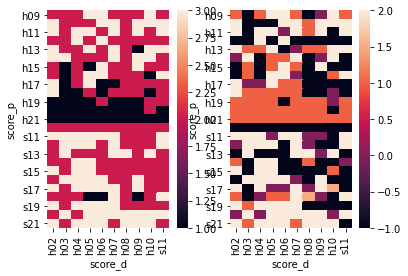

In [41]:


%prun -s cumulative opt.run_iteration(1, strat_simple, None)

In [42]:
# Memoized strategy
# Rather than generic conditions, just use an array indexed on player and dealer scores
# Since that's how we're generating our strategy anyway (one square at a time)

instructions = {(repr(HandScore(13, True)), repr(HandScore(6))): Action.HIT}
strat_memoized = opt.gen_strat_memoized(instructions, strat_simple)

sims = sim.run_n_sim_trials([strat_simple, strat_memoized], 1000)
sims.head(10), sim.summarize_totals(sims)

(   strategy hand_start  dealer_card   hand_end       dealer_hand  \
 0    simple     [9, 1]            7     [9, 1]   [7, 4, 4, 1, 7]   
 1  memoized     [9, 1]            7     [9, 1]   [7, 4, 4, 1, 7]   
 2    simple     [4, 7]            3  [4, 7, 1]     [3, 3, 12, 1]   
 3  memoized     [4, 7]            3  [4, 7, 7]     [3, 3, 12, 1]   
 4    simple    [13, 2]            3    [13, 2]      [3, 2, 7, 7]   
 5  memoized    [13, 2]            3    [13, 2]      [3, 2, 7, 7]   
 6    simple    [9, 11]           13    [9, 11]        [13, 3, 4]   
 7  memoized    [9, 11]           13    [9, 11]        [13, 3, 4]   
 8    simple   [13, 13]            5   [13, 13]  [5, 5, 5, 1, 11]   
 9  memoized   [13, 13]            5   [13, 13]  [5, 5, 5, 1, 11]   
 
                    outcome  outcome_value outcome_name  
 0          HandOutcome.WIN            1.0          WIN  
 1          HandOutcome.WIN            1.0          WIN  
 2  HandOutcome.LOSE_DOUBLE           -2.0  LOSE_DOUBLE  
 3   Ha

0
1
('h09', 'h05') Action.HIT Action.DOUBLE
('h09', 'h06') Action.DOUBLE Action.HIT
('h09', 'h09') Action.HIT Action.DOUBLE
('h10', 'h02') Action.DOUBLE Action.HIT
('h10', 'h03') Action.DOUBLE Action.HIT
('h10', 'h08') Action.DOUBLE Action.HIT
('h10', 'h09') Action.DOUBLE Action.HIT
('h10', 'h10') Action.HIT Action.DOUBLE
('h11', 'h07') Action.HIT Action.DOUBLE
('h11', 'h09') Action.HIT Action.DOUBLE
('h12', 'h04') Action.HIT Action.STAND
('h12', 'h06') Action.HIT Action.STAND
('h12', 'h08') Action.HIT Action.DOUBLE
('h13', 'h03') Action.HIT Action.STAND
('h13', 'h05') Action.STAND Action.HIT
('h13', 'h06') Action.STAND Action.HIT
('h13', 'h10') Action.HIT Action.DOUBLE
('h14', 'h06') Action.STAND Action.DOUBLE
('h14', 'h07') Action.HIT Action.STAND
('h15', 's11') Action.STAND Action.HIT
('h15', 'h02') Action.STAND Action.HIT
('h15', 'h07') Action.HIT Action.STAND
('h15', 'h08') Action.STAND Action.HIT
('h16', 's11') Action.STAND Action.HIT
('h16', 'h09') Action.HIT Action.STAND
('h16'

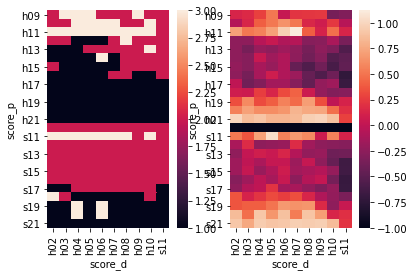

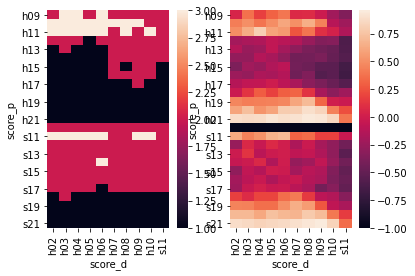

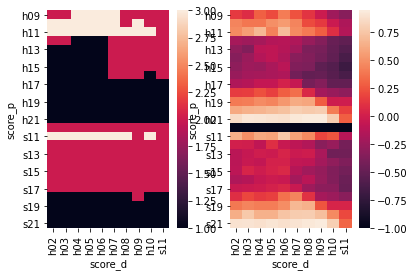

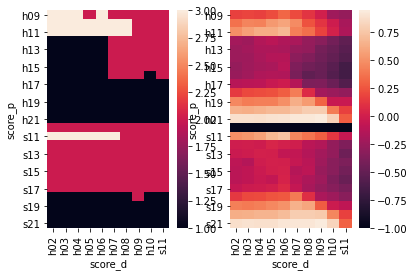

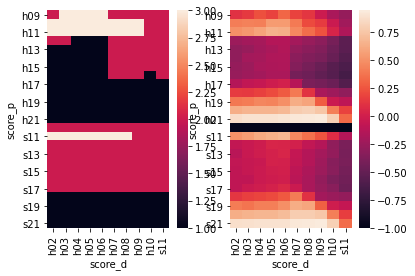

In [43]:


strategies = opt.derive_iterative_strategies(strat_simple, 5)
strategies

In [44]:
sims = sim.run_n_sim_trials(strategies, 1000*1000)
sims.head(10), sim.summarize_totals(sims)

(  strategy hand_start  dealer_card             hand_end dealer_hand  \
 0   simple   [10, 11]           11             [10, 11]  [11, 2, 6]   
 1  iter(1)   [10, 11]           11             [10, 11]  [11, 2, 6]   
 2  iter(2)   [10, 11]           11             [10, 11]  [11, 2, 6]   
 3  iter(3)   [10, 11]           11             [10, 11]  [11, 2, 6]   
 4  iter(4)   [10, 11]           11             [10, 11]  [11, 2, 6]   
 5  iter(5)   [10, 11]           11             [10, 11]  [11, 2, 6]   
 6   simple     [3, 7]            8            [3, 7, 8]   [8, 3, 8]   
 7  iter(1)     [3, 7]            8      [3, 7, 5, 1, 6]   [8, 3, 8]   
 8  iter(2)     [3, 7]            8            [3, 7, 6]   [8, 3, 8]   
 9  iter(3)     [3, 7]            8  [3, 7, 4, 1, 1, 12]   [8, 3, 8]   
 
                    outcome  outcome_value outcome_name  
 0          HandOutcome.WIN            1.0          WIN  
 1          HandOutcome.WIN            1.0          WIN  
 2          HandOutcome.WIN     

In [45]:
strategies

In [46]:
import pickle

In [47]:
with open('strategies.pickle', 'wb') as handle:
    pickle.dump(strategies, handle, protocol=pickle.HIGHEST_PROTOCOL)